In [11]:
from mpc_nn_model_safe import *
from platform import python_version

print(python_version())

3.8.8


In [16]:
####### Parameters #######
n_epochs=200
min_timesteps=50
n_rollout=10
n_skips_per_rollout=0
n_test=1
n_input=6
n_output=n_rollout*3 # 3 for each of the next n_rollout time steps
n_state_enc=4
learning_rate=0.0003
gen_model=1
pred_model=1
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Load the network ##
mpc_nn_predictor_safe=MPC_NN_Predictor(n_epochs,min_timesteps,n_rollout,n_skips_per_rollout,n_test,n_input,n_output,n_state_enc,learning_rate,gen_model,pred_model,device)
mpc_nn_predictor_safe.load_model_weights("encoder_rnn_decoder_simple_nn_n_rollout_n_skips_MSELOSS_action_t_included_for_results")



names of files-Encoder ../trained_models/IRL_based_models/IRL_SVOpolicy_ais_gen1_816_pred1_24_epochs200_learning_rate0.0003_hidden_states4encoder_rnn_decoder_simple_nn_n_rollout_n_skips_MSELOSS_action_t_included_for_results.pth 

names of files-Decoder ../trained_models/IRL_based_models/IRL_SVOpolicy_ais_pred1_24_gen1_816_epochs200_learning_rate0.0003_hidden_states4encoder_rnn_decoder_simple_nn_n_rollout_n_skips_MSELOSS_action_t_included_for_results.pth 



'loaded the weights!'

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy.linalg as LA
from scipy.integrate import odeint
from timeit import default_timer as timer
from scipy.optimize import fmin, minimize


In [35]:
import sys
if sys.platform == 'win32' or sys.platform == 'win64': # Change to suit the OS
    sys.path.append(r"C:\Users\vietale\Documents\casadi-windows-py39-v3.5.5-64bit")
else:
    sys.path.append(r"casadiinstalldir")
import casadi as ca

In [36]:
from vehicle import *

In [37]:
class MPC:
    
    def __init__(self, H, T, bounds):
        self.H = H; self.T = T
        self.u_min = bounds['u_min']; self.u_max = bounds['u_max']
        self.v_min = bounds['v_min']; self.v_max = bounds['v_max']

    def set_state(self, st, input):
        self.input = input
        self.state = st
        
    def set_road_info(self, r):
        self.r = r
        
    def set_weight(self, W1, W12):
        self.W1 = W1; self.W12 = W12

    def compute_objective(self, PA, VA, UA, PH, VH):
        cost = 0
        for k in range(self.H):
            cost += self.W1[0]*UA[k]**2 + self.W1[1]*(VA[k] - self.v_max)**2
            cost += -self.W12*ca.log((PA[k]+0.5*VA[k])**2 + (PH[k]+0.5*VH[k])**2 + 1e-6) 

        return cost

    def formulateMPC(self):
        # Create MPC optimizer
        self.mpc_opti = ca.Opti()
        
        # Variables for CAV
        self.U = self.mpc_opti.variable(self.H)
        self.V = self.mpc_opti.variable(self.H)
        self.P = self.mpc_opti.variable(self.H)
            
        self.X0 = self.mpc_opti.parameter(2) # initial condition of CAV state
        self.PH = self.mpc_opti.parameter(self.H) # the positions of the HDV over the horizon
        self.VH = self.mpc_opti.parameter(self.H) # the speeds of the HDV over the horizon

        # Objective function
        self.J = 0
        for k in range(self.H):
            self.J += self.W1[0]*self.U[k]**2 + self.W1[1]*(self.V[k] - self.v_max)**2
            self.J += -self.W12*ca.log((self.P[k]+0.5*self.V[k])**2 + (self.PH[k]+0.5*self.VH[k])**2 + 1e-6)
            if k == 0:
                self.J += self.W1[2]*(self.U[k]- self.input)**2
            else:
                self.J += self.W1[2]*(self.U[k]- self.U[k-1])**2
        
        self.mpc_opti.minimize(self.J) 
        
        # Dynamics
        for k in range(self.H):
            if k == 0:
                self.mpc_opti.subject_to(self.P[k] == self.X0[0] + self.T*self.X0[1] \
                                            + 0.5*self.T**2*self.U[k])
                self.mpc_opti.subject_to(self.V[k] == self.X0[1] + self.T*self.U[k])            
            else:
                self.mpc_opti.subject_to(self.P[k] == self.P[k-1] + self.T*self.V[k-1] \
                                            + 0.5*self.T**2*self.U[k])
                self.mpc_opti.subject_to(self.V[k] == self.V[k-1] + self.T*self.U[k])
            
         # Constraints
        self.mpc_opti.subject_to(self.v_min <= self.V)
        self.mpc_opti.subject_to(self.V <= self.v_max)
        self.mpc_opti.subject_to(self.u_min <= self.U)
        self.mpc_opti.subject_to(self.U <= self.u_max)
        # self.D = (self.P+1.0*self.V)**2 + (self.PH+1.0*self.VH)**2 
        # self.mpc_opti.subject_to(self.r**2 <= self.D)
        
        p_opts = {'verbose_init': False}
        s_opts = {'tol': 0.001, 'print_level': 0, 'max_iter': 100}
        self.mpc_opti.solver('ipopt', p_opts, s_opts)

        # Warm up
        self.mpc_opti.set_value(self.X0, self.state)
        self.mpc_opti.set_value(self.PH, np.zeros(self.H))
        self.mpc_opti.set_value(self.VH, np.zeros(self.H))
         
        try:
            sol = self.mpc_opti.solve()
            
        except RuntimeError:
            print("An exception occurred")
            self.mpc_opti.set_initial(self.U, self.mpc_opti.debug.value(self.U))
        else:
            self.mpc_opti.set_initial(self.U, sol.value(self.U))
            self.mpc_opti.set_initial(self.V, sol.value(self.V))
            self.mpc_opti.set_initial(self.P, sol.value(self.P))
        
    def solveMPC(self, PH, VH):
        self.mpc_opti.set_value(self.X0, self.state)
        self.mpc_opti.set_value(self.PH, PH)
        self.mpc_opti.set_value(self.VH, VH)

        try:
            sol = self.mpc_opti.solve()
        except RuntimeError:
            print("An exception occurred")
            OUT = {'P': sol.value(self.P), 'V': self.mpc_opti.debug.value(self.V), 'U': self.mpc_opti.debug.value(self.U)}
        else:
            OUT = {'P': self.mpc_opti.debug.value(self.P), 'V': sol.value(self.V), 'U': sol.value(self.U)} 
            self.mpc_opti.set_initial(self.U, np.hstack((sol.value(self.U)[1:], sol.value(self.U)[-1:])))    
            self.mpc_opti.set_initial(self.V, np.hstack((sol.value(self.V)[1:], sol.value(self.V)[-1:])))    
            self.mpc_opti.set_initial(self.P, np.hstack((sol.value(self.P)[1:], sol.value(self.P)[-1:])))    
                      
        return OUT


## Main simulation

In [70]:
np.random.seed(28)
T = 0.2; H = 10; Ts = 0.05
bounds = {'v_min' : 0.0, 'v_max' : 14.0, 'u_min' : -3.0, 'u_max' : 2.0}
r = 10.0 

Cars = []
Cars.append(CAV(-72.0, 10.4, bounds, T, Ts))
Cars.append(HDV(-70.0, 9.9, bounds, T, Ts))

control = MPC(H, T, bounds)
control.set_road_info(r)
control.set_state(Cars[0].state, Cars[0].u)
W1 = np.array([1e0,1e1,1e1])
W2 = np.array([1e-2,2e-1]); W12 = 1e3
control.set_weight(W1, W12)
control.formulateMPC()
latest_observation=[Cars[0].p, Cars[1].p, Cars[0].v, Cars[1].v]
previous_action=[Cars[0].u, Cars[1].u]
ais_encoder_previous=0

Cars[0].const_U(0.0, 0.0)
Cars[1].const_U(Cars[1].IRL(Cars[0].state, np.hstack([W2, W12])), 0.0)

current_CAV_action = 0.0
nn_prediction,ais_encoder_previous=mpc_nn_predictor.nn_prediction_model(latest_observation,previous_action,ais_encoder_previous,current_CAV_action,time_step=0)
prediction = nn_prediction.detach().cpu().numpy()
prediction = prediction.reshape([3,-1], order = 'F')


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 494.00us ( 29.06us) 501.52us ( 29.50us)        17
       nlp_g  | 448.00us ( 26.35us) 493.50us ( 29.03us)        17
    nlp_grad  |  52.00us ( 52.00us)  52.09us ( 52.09us)         1
  nlp_grad_f  | 677.00us ( 37.61us) 748.49us ( 41.58us)        18
  nlp_hess_l  | 894.00us ( 55.88us)   1.04ms ( 65.09us)        16
   nlp_jac_g  | 987.00us ( 54.83us)   1.03ms ( 57.24us)        18
       total  |  21.61ms ( 21.61ms)  23.19ms ( 23.19ms)         1


In [71]:
L = 100 # number of simulation steps
ite = 5
for k in range(L):
    t = (k+1)*T
    print("Time %s" %t)
    control.set_state(Cars[0].state, Cars[0].u)

    latest_observation=[Cars[0].p, Cars[1].p, Cars[0].v, Cars[1].v]
    previous_action=[Cars[0].u, Cars[1].u]

    COST = []
    U1 = [0.0]; current_CAV_action = 0.0
    for i in range(ite):
        nn_prediction,ais_encoder_previous=mpc_nn_predictor.nn_prediction_model(latest_observation,previous_action,ais_encoder_previous,current_CAV_action,time_step=0)
        prediction = nn_prediction.detach().cpu().numpy()
        prediction = prediction.reshape([3,-1], order = 'F')
        PH = prediction[0,:]; VH = prediction[1,:]
        TRAJ = control.solveMPC(PH, VH)
        c = control.compute_objective(TRAJ['P'], TRAJ['V'], TRAJ['U'], PH, VH)
        COST.append(c)
        current_CAV_action = TRAJ['U'][0]
        U1.append(current_CAV_action)

    print(COST, U1)
    u1 = U1[-1]
    u2 = Cars[1].IRL(Cars[0].state, np.hstack([W2, W12]))
    U = [u1, u2]
    Cars[0].const_U(u1, t)
    Cars[1].const_U(u2, t)

    if Cars[0].p > 0.0 or Cars[1].p > 0.0:
        break

Time 0.2
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 131.00us ( 21.83us) 133.29us ( 22.22us)         6
       nlp_g  |  95.00us ( 15.83us)  95.43us ( 15.90us)         6
    nlp_grad  |  76.00us ( 76.00us)  75.59us ( 75.59us)         1
  nlp_grad_f  | 218.00us ( 31.14us) 216.68us ( 30.95us)         7
  nlp_hess_l  | 198.00us ( 39.60us) 197.16us ( 39.43us)         5
   nlp_jac_g  | 315.00us ( 45.00us) 316.98us ( 45.28us)         7
       total  |   6.43ms (  6.43ms)   6.51ms (  6.51ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 155.00us ( 25.83us) 155.62us ( 25.94us)         6
       nlp_g  | 116.00us ( 19.33us) 115.12us ( 19.19us)         6
    nlp_grad  |  87.00us ( 87.00us)  99.88us ( 99.88us)         1
  nlp_grad_f  | 294.00us ( 42.00us) 328.76us ( 46.97us)         7
  nlp_hess_l  | 197.00us ( 39.40us) 200.94us ( 40.19us)         5
   nlp_jac_g  | 346.00us ( 49.43us) 360.73us ( 51.53us)         7
 

In [72]:
L = Cars[0].X_hist[0,:].shape[0]

X_hist = np.zeros((2,3,L))
for i in range(2):
    X_hist[i,0,:] = Cars[i].X_hist[0,:]
    X_hist[i,1,:] = Cars[i].X_hist[1,:]
    X_hist[i,2,:-1] = Cars[i].U_hist

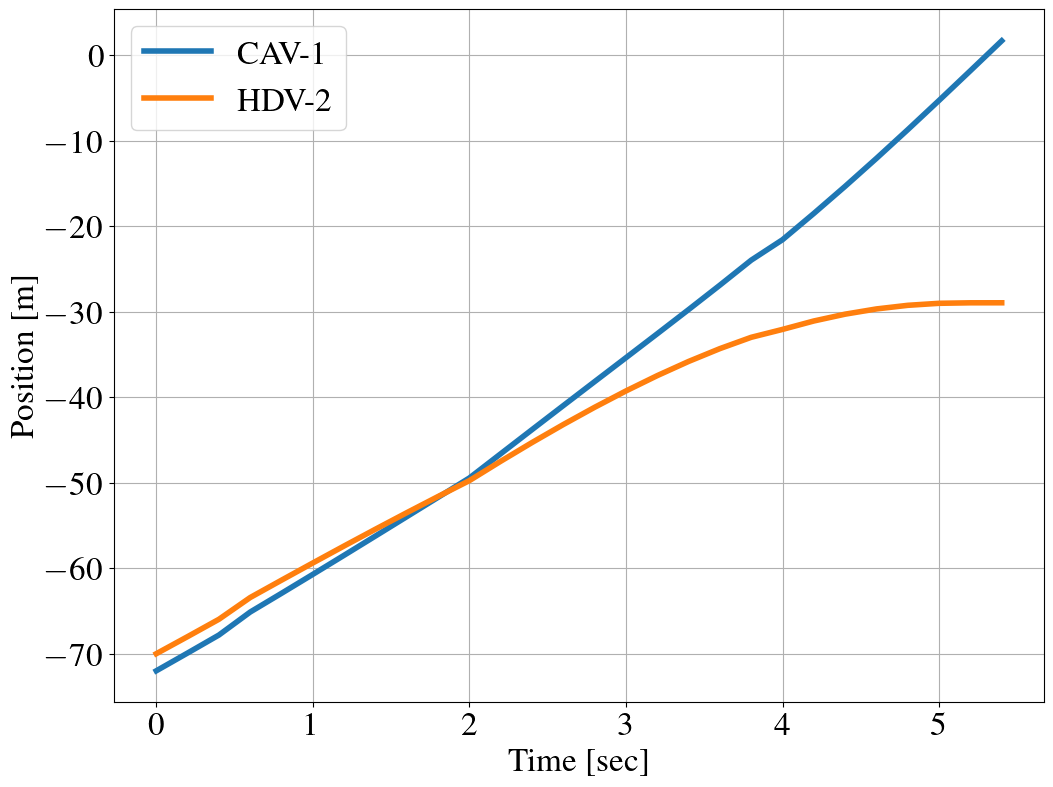

In [80]:
t_series = T*np.linspace(0,L-1,num=L)
%matplotlib inline
plt.rcParams["font.family"] = "Times"
plt.rcParams['font.size'] = '24'
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(12,9))
%matplotlib inline
name = ["CAV-1", "HDV-2"]
for i in range(2):
    plt.plot(t_series, X_hist[i,0,:], label = name[i], lw = 4)
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')

filename = 'sim2_position.pdf'
plt.savefig(filename)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


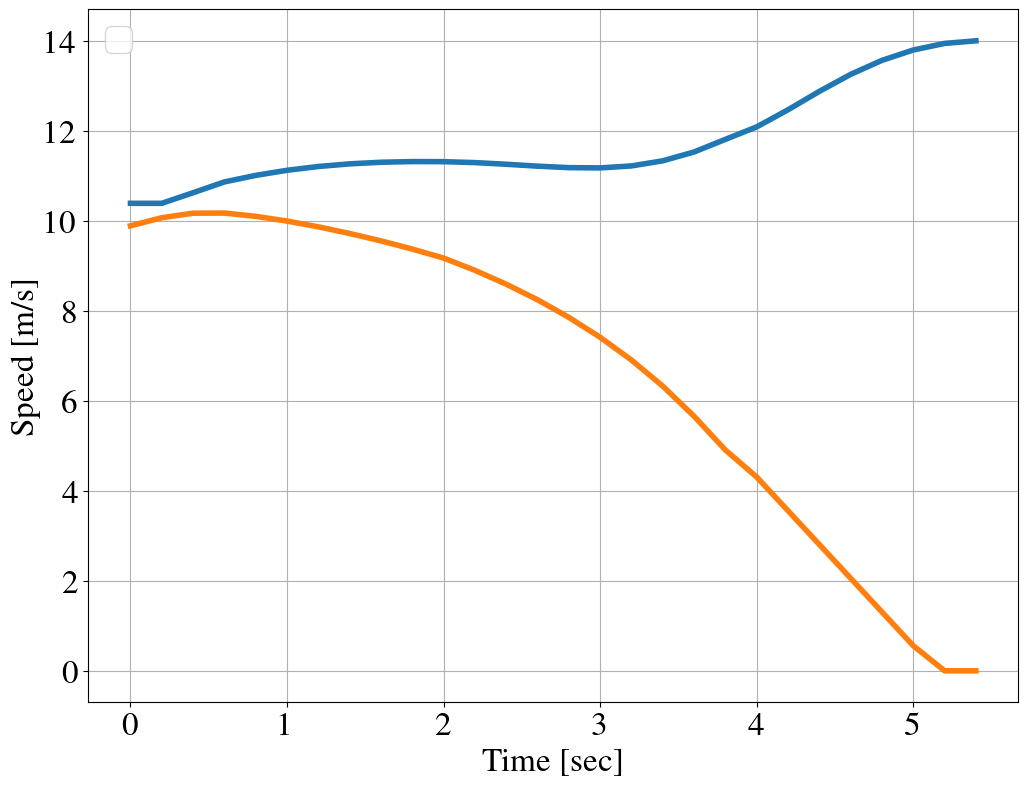

In [79]:
%matplotlib inline
plt.rcParams["font.family"] = "Times"
plt.rcParams['font.size'] = '24'
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(12,9))
for i in range(2):
    plt.plot(t_series, X_hist[i,1,:], lw = 4)
plt.legend(loc="upper left")
plt.xlabel('Time [sec]')
plt.ylabel('Speed [m/s]')
plt.grid()

filename = 'sim2_speed.pdf'
plt.savefig(filename)

In [76]:
def distance(p1, p2, angle):
    if p2 <= 0:
        dist = np.sqrt(p1**2 + p2**2 - 2*np.cos(angle)*p1*p2)
    elif p2 > 0:
        dist = np.abs(p1-p2)
    return dist
d = np.zeros(L)
for i in range(L):
    p1 = X_hist[0,0,i]; p2 = X_hist[1,0,i]
    d[i] = distance(p1, p2, np.pi/6)

Text(0, 0.5, 'Distance (m)')

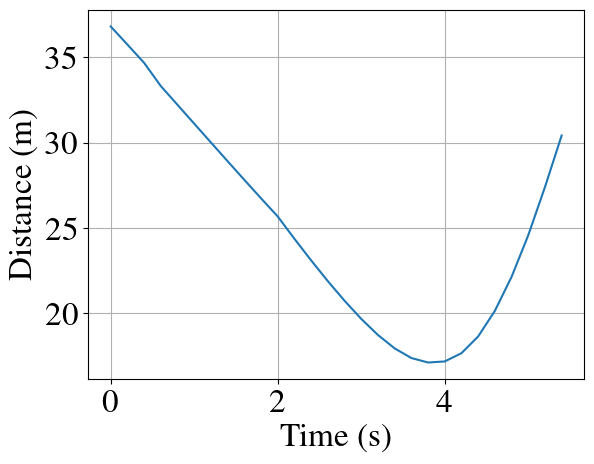

In [77]:
plt.plot(t_series, d, label = "Vehicle " + str(i))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


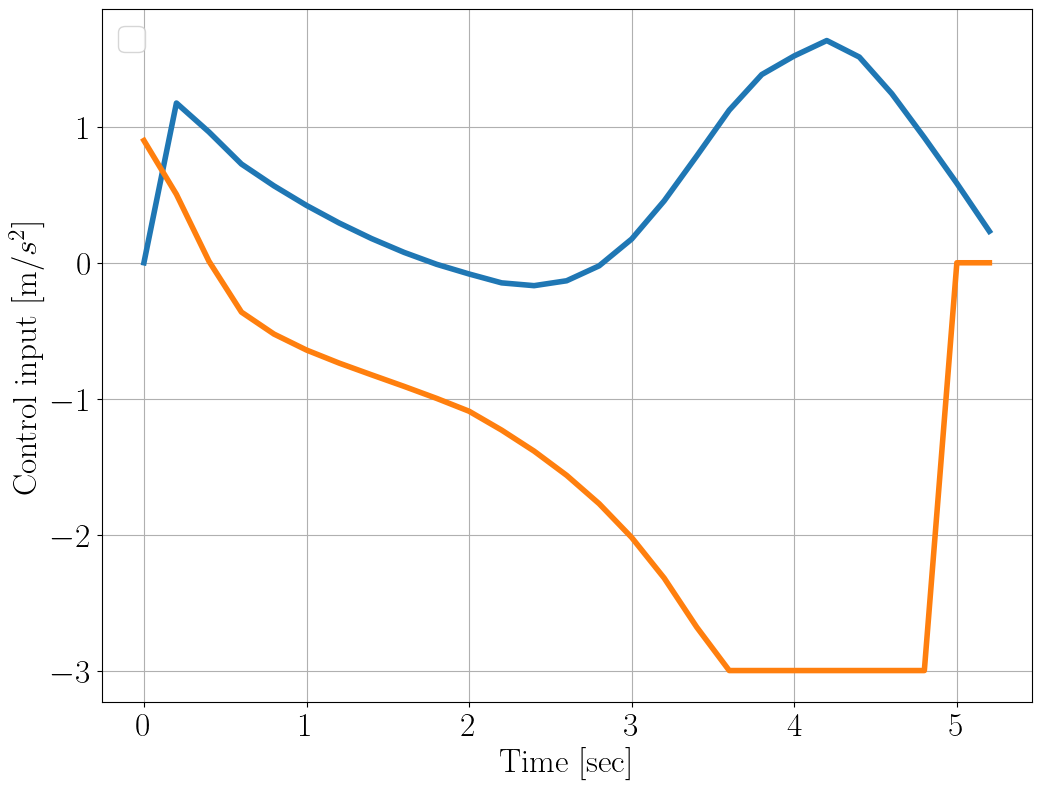

In [78]:
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = '24'
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(12,9))
for i in range(2):
    plt.plot(t_series[:-1], X_hist[i,2,:-1], lw = 4)
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time [sec]')
plt.ylabel('Control input [m/$s^2$]')

filename = 'sim2_input.pdf'
plt.savefig(filename)